In [1]:
from scipy.stats.distributions import chi2

import matplotlib.pylab as plt
import json
import pandas as pd
import os
import seaborn as sns
import numpy as np

import itertools
import random
import copy
import time

In [56]:
script_path = 'javascript/analysis/models.wppl'
data_path = 'experiment/webppl-input/'

# Grid Search Parameters

In [3]:
# PARTICIPANT_GRID_PARAM_PATH = "experiment/webppl-{}/participant_gridsearch_mle_params.json"

def grid_search_likelihoods(output_directory, input_files, input_type="select", likelihood="original", 
                            params="", verbose=True, output_fname_extension=""): 

    try:
        os.mkdir(output_directory)
    except:
        pass

    for input_file in input_files:

        output_file = f'gridsearch-LH-{likelihood}{output_fname_extension}-{input_file}'    
        existing_files = os.listdir(output_directory)

        file_exists = [f for f in existing_files if output_file == f]
        
        if file_exists and verbose:
            print("Found existing {}".format(output_file))
        
        else:

            print("Could not find {}.".format(output_file))

            script = '{} --require actions --require webppl-json -- --gridsearch --fname {} --fpath {} --outpath {} --inputType {} --likelihood {} --{}'
            script = script.format(script_path, input_type + "/" + input_file, data_path, output_directory + output_file, input_type, likelihood, params)
        
            start_time_ms = round(time.time() * 1000)
            os.system("webppl {}".format(script))
            end_time_ms = round(time.time() * 1000)

            print("\tRan {} in {:.2f} minutes.".format(input_file, (end_time_ms - start_time_ms)/1000/60)) 

## Analyze Gridsearch

In [4]:
def concat_participant_gridsearch_likelihoods(exp):
        
    input_dir = "experiment/webppl-{}/gridsearch/participants/".format(exp)

    gridsearch_results_dfs = []
    existing_files = [s for s in os.listdir(input_dir) if "json" in s]

    for file in existing_files:
            
            file_path = input_dir + file
            try:
                gridsearch_results = pd.DataFrame(json.load(open(file_path)))
                gridsearch_results["workerid"] = file.split(".")[0].split("-")[-1]
                gridsearch_results_dfs.append(gridsearch_results)
            except FileNotFoundError:
                print("Failed to find {}.".format(file_path))

    df = pd.concat(gridsearch_results_dfs)
    return df

def mles_from_participant_gridsearch(exp):
    
    full_df = concat_participant_gridsearch_likelihoods(exp)
    
    return full_df.sort_values('likelihood', ascending=False).drop_duplicates(['workerid'])

def model_likelihoods_from_gridsearch(df):
    
    combined = df.sort_values('likelihood', ascending=False).iloc[0]["likelihood"]
    belief = df[df.utilityWeight==0].sort_values('likelihood', ascending=False).iloc[0]["likelihood"]
    utility = df[df.utilityWeight==1].sort_values('likelihood', ascending=False).iloc[0]["likelihood"]

    return {"combined": combined, "belief": belief, "utility": utility}


## Model Comparisons - Likelihood Ratios

In [5]:
def likelihood_ratio(log_likelihood1, log_likelihood2, dof):
    """N.B.: DOF should be 2 for Belief (utilityWeight and alphaL) and 1 for Utility (utilityWeight)"""

    # chi^2(df)=ratio, p = ...
    
    ratio = 2 * (log_likelihood1 - log_likelihood2)
    pval = chi2.sf(ratio, dof)
    
    print(f'chisq({dof}) = {ratio}, p = {pval}')
    return pval

def likelihood_ratio_test(m1, m2, dof):
    """Assumes that m1/m2 are dataframes with parameter values from grid search. Return likelihood ratio results."""
    
    m1_best_params = m1.loc[m1['likelihood'].idxmax()]
    m2_best_params = m2.loc[m2['likelihood'].idxmax()]
    
    print(f'M1 best: UW = {m1_best_params["utilityWeight"]}, alphaS = {m1_best_params["alphaS"]}, log-likelihood: {m1_best_params["likelihood"]}')
    print(f'M2 best: UW = {m2_best_params["utilityWeight"]}, alphaS = {m2_best_params["alphaS"]}, log-likelihood: {m2_best_params["likelihood"]}')
    
    pval = likelihood_ratio(m1_best_params["likelihood"], m2_best_params["likelihood"], dof)
    
    return pval

# Bayes Factors

In [6]:
from scipy.special import logsumexp

def average_log_probability(df):
    
    total_log_prob = logsumexp(df.likelihood)
    
    # Assume a uniform prior, so "divide" by the number of grid points that went into this
    return total_log_prob - np.log(len(df))

def bayes_factors(m1, m2):
    
    print(f'Comparing M1 ({len(m1)} rows) to M2 ({len(m2)} rows).')
    
    m1_log_prob = average_log_probability(m1)
    m2_log_prob = average_log_probability(m2)
        
    log_bayes_factor =  m1_log_prob - m2_log_prob
    bayes_factor = np.exp(log_bayes_factor)

    print("Bayes Factor (M1 / M2): {}".format(bayes_factor))
    print("Log Bayes Factor: {}".format(log_bayes_factor))
    print("\tM1: {}\n\tM2: {}".format(m1_log_prob, m2_log_prob))

# Experiment 1

In [7]:
conditions = ["ambiguous", "belief", "utility"]
models = ["combined", "belief", "utility"]

input_string = "{}-exp1.json"

input_files = []
for cond in conditions:
    input_files.append(input_string.format(cond))

## Grid Search Parameter Space

In [8]:
output_dir = "experiment/webppl-exp1/gridsearch/"

grid_search_likelihoods(output_dir, input_files)

Found existing gridsearch-LH-original-ambiguous-exp1.json
Found existing gridsearch-LH-original-belief-exp1.json
Found existing gridsearch-LH-original-utility-exp1.json


In [9]:
def print_mle(df):
    
    mle = df.loc[df.likelihood.idxmax()]
    print(f'\tMLE: UW = {mle["utilityWeight"]}, alphaS = {mle["alphaS"]}, alphaL = {mle["alphaL"]}, log-likelihood: {round(mle["likelihood"], 2)}')



ambiguous-exp1.json
      utilityWeight  alphaS  alphaL  falsePenalty   likelihood  valenceWeight
4893           0.55       3       2            -1 -4777.744606           0.25
5393           0.50       3       2            -1 -4787.299626           0.25
5388           0.50       3       3            -1 -4802.834423           0.25
4888           0.55       3       3            -1 -4804.421262           0.25
4393           0.60       3       2            -1 -4804.633996           0.25
	MLE: UW = 0.0, alphaS = 2.0, alphaL = 10.0, log-likelihood: -5911.11
	MLE: UW = 1.0, alphaS = 2.0, alphaL = 2.0, log-likelihood: -6282.39
	MLE: UW = 0.55, alphaS = 3.0, alphaL = 2.0, log-likelihood: -4777.74


belief-exp1.json
      utilityWeight  alphaS  alphaL  falsePenalty   likelihood  valenceWeight
6899           0.35       3       1            -1 -4555.964844            0.0
6399           0.40       3       1            -1 -4558.628748            0.0
7394           0.30       3       2            -

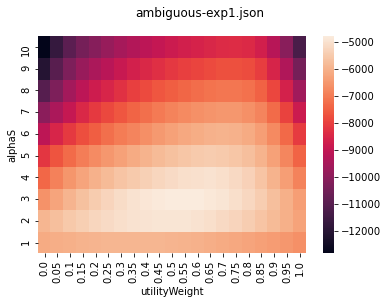

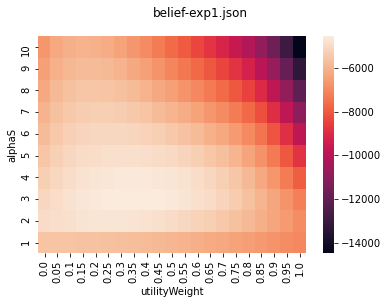

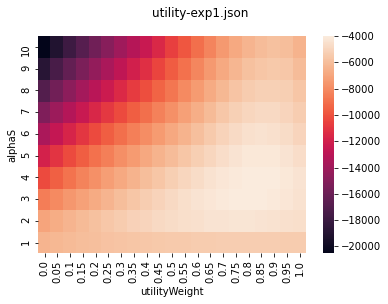

In [10]:
for input_file in input_files:

    inputs = json.load(open("experiment/webppl-exp1/gridsearch/gridsearch-LH-original-{}".format(input_file)))
    df = pd.DataFrame.from_records(inputs)
    df = df[df.falsePenalty == -1]
    df["utilityWeight"] = df.utilityWeight.round(2)
    
    print("\n\n"  + input_file)
    print(df.sort_values("likelihood", ascending=False)[["utilityWeight", "alphaS", "alphaL", "falsePenalty", "likelihood", "valenceWeight"]].head(5))
    
    print_mle(df[df.utilityWeight == 0])
    print_mle(df[df.utilityWeight == 1])
    print_mle(df)
    
    plt.figure()

    pivoted = df.pivot_table(values='likelihood', columns="utilityWeight", index="alphaS", aggfunc='max')
    ax = sns.heatmap(pivoted)
    ax.invert_yaxis()
    plt.suptitle(input_file)

In [11]:
grid_search_likelihoods(output_dir, input_files, likelihood="qud", params="qudParams") 

inputs = json.load(open("experiment/webppl-exp1/gridsearch/gridsearch-LH-qud-ambiguous-exp1.json".format(input_file)))
df = pd.DataFrame.from_records(inputs)

print("\n\n"  + input_file)
print(df.sort_values("likelihood", ascending=False)[["alphaS", "falsePenalty", "likelihood"]].head(5))

Found existing gridsearch-LH-qud-ambiguous-exp1.json
Found existing gridsearch-LH-qud-belief-exp1.json
Found existing gridsearch-LH-qud-utility-exp1.json


utility-exp1.json
   alphaS  falsePenalty    likelihood
9       1            -1  -6510.124654
8       2            -1  -7521.862735
7       3            -1  -9850.383400
6       4            -1 -12494.810844
5       5            -1 -15245.429502


### Bayes Factors

In [12]:
combined = pd.DataFrame(json.load(open("experiment/webppl-exp1/gridsearch/gridsearch-LH-original-ambiguous-exp1.json")))
combined.sort_values('likelihood', ascending=False).head(3)

,utilityWeight,alphaS,alphaL,valenceWeight,falsePenalty,sigmaGaussian,likelihood
4893,0.55,3,2,0.25,-1,30,-4777.744606
5393,0.50,3,2,0.25,-1,30,-4787.299626
5388,0.50,3,3,0.25,-1,30,-4802.834423


In [13]:
combined["utilityWeight"] = combined.utilityWeight.round(2)

print("\nBF for combined vs pure belief:")
belief_only = combined[combined.utilityWeight == 0]
bayes_factors(combined, belief_only)

print("\nBF for combined vs pure utility")
utility_only = combined[combined.utilityWeight == 1]
bayes_factors(combined, utility_only)

print("\nBF for combined vs QUD")
qud_raw = json.load(open("experiment/webppl-exp1/gridsearch/gridsearch-LH-qud-ambiguous-exp1.json"))
qud = pd.DataFrame.from_records(qud_raw)
bayes_factors(combined, qud)

print("\nBF for QUD vs utility only")
bayes_factors(qud, utility_only)


BF for combined vs pure belief:
Comparing M1 (10500 rows) to M2 (500 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 1128.021122099487
	M1: -4787.003665476623
	M2: -5915.02478757611

BF for combined vs pure utility
Comparing M1 (10500 rows) to M2 (500 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 1501.6039763401104
	M1: -4787.003665476623
	M2: -6288.607641816733

BF for combined vs QUD
Comparing M1 (10500 rows) to M2 (10 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 1725.4235732378538
	M1: -4787.003665476623
	M2: -6512.4272387144765

BF for QUD vs utility only
Comparing M1 (10 rows) to M2 (500 rows).
Bayes Factor (M1 / M2): 6.257258911612616e-98
Log Bayes Factor: -223.8195968977434
	M1: -6512.4272387144765
	M2: -6288.607641816733


/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_20917/277710767.py:18: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_bayes_factor)
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_20917/277710767.py:18: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_bayes_factor)


### Likelihood Ratios

In [14]:
print("\nCombined vs Belief-Only") 
likelihood_ratio_test(combined, belief_only, 2)

print("\nCombined vs Action-Only") 
likelihood_ratio_test(combined, utility_only, 1)


Combined vs Belief-Only
M1 best: UW = 0.55, alphaS = 3.0, log-likelihood: -4777.744605782671
M2 best: UW = 0.0, alphaS = 2.0, log-likelihood: -5911.112764570682
chisq(2) = 2266.736317576022, p = 0.0

Combined vs Action-Only
M1 best: UW = 0.55, alphaS = 3.0, log-likelihood: -4777.744605782671
M2 best: UW = 1.0, alphaS = 2.0, log-likelihood: -6282.393033718311
chisq(1) = 3009.29685587128, p = 0.0


0.0

### Objective Manipulation Checks (joint gridsearch)

In [15]:
output_dir = "experiment/webppl-exp1/gridsearch/cross-condition/"

for alphaS in range(1, 11):
    grid_search_likelihoods(output_dir, ["ALL-exp1.json"], input_type='select', 
                            params=f'byObjective {alphaS}', output_fname_extension=f'-alphaS-{alphaS}')

Found existing gridsearch-LH-original-alphaS-1-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-2-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-3-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-4-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-5-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-6-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-7-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-8-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-9-ALL-exp1.json
Found existing gridsearch-LH-original-alphaS-10-ALL-exp1.json


In [16]:
outputs = [o for o in os.listdir(output_dir) if "json" in o]

results = []
for file in outputs:
    results.append(pd.read_json(open(output_dir + file)))

df = pd.concat(results)

In [17]:
df.sort_values('likelihood', ascending=False).iloc[0]

utilityWeight-belief           0.300000
utilityWeight-utility          0.800000
utilityWeight-ambiguous        0.600000
alphaS                         3.000000
alphaL                         2.000000
falsePenalty                  -1.000000
sigmaGaussian                 30.000000
likelihood                -14066.282009
Name: 8738, dtype: float64

In [18]:
ordinal_model = df[(df["utilityWeight-utility"] > df["utilityWeight-ambiguous"]) &
                   (df["utilityWeight-ambiguous"] > df["utilityWeight-belief"])]

single_param_model = df[(df["utilityWeight-utility"] == df["utilityWeight-ambiguous"]) & 
                        (df["utilityWeight-ambiguous"] == df["utilityWeight-belief"])]

print("Exp 1: Objective Comparisons (Belief - Ambiguous - Utility)")

print("\nBF for ordinal-vs-single:")
bayes_factors(ordinal_model, single_param_model)

print("\nBF for ordinal-vs-independent:")
bayes_factors(ordinal_model, df)

Exp 1: Objective Comparisons (Belief - Ambiguous - Utility)

BF for ordinal-vs-single:
Comparing M1 (16500 rows) to M2 (1100 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 1019.3971534525499
	M1: -14075.99312464596
	M2: -15095.39027809851

BF for ordinal-vs-independent:
Comparing M1 (16500 rows) to M2 (133100 rows).
Bayes Factor (M1 / M2): 8.066666666660733
Log Bayes Factor: 2.0877403444937954
	M1: -14075.99312464596
	M2: -14078.080864990454


/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_20917/277710767.py:18: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_bayes_factor)


In [19]:
len(ordinal_model)

16500

## Individual Participants

In [20]:
exp1_worker_input_files = os.listdir("experiment/webppl-input/select/participants/")

In [22]:
output_dir = "experiment/webppl-exp1/gridsearch/participants/"

grid_search_likelihoods(output_dir, exp1_worker_input_files, input_type="select/participants")

Found existing gridsearch-LH-original-Waa8a33b5ee.json
Found existing gridsearch-LH-original-Wf04d15855b.json
Found existing gridsearch-LH-original-W88c35993e1.json
Found existing gridsearch-LH-original-W0e8679fbe6.json
Found existing gridsearch-LH-original-Wf079dbc595.json
Found existing gridsearch-LH-original-W558ac13f51.json
Found existing gridsearch-LH-original-Wff0e2d2450.json
Found existing gridsearch-LH-original-Wf39cba4836.json
Found existing gridsearch-LH-original-W6813913920.json
Found existing gridsearch-LH-original-W98000b74c5.json
Found existing gridsearch-LH-original-Wb437f29e48.json
Found existing gridsearch-LH-original-Wea9c1e333d.json
Found existing gridsearch-LH-original-W494fd8d3db.json
Found existing gridsearch-LH-original-W4609343ccc.json
Found existing gridsearch-LH-original-Wba724ed740.json
Found existing gridsearch-LH-original-Wb8d8313695.json
Found existing gridsearch-LH-original-W118b9eeebd.json
Found existing gridsearch-LH-original-Wdd8db04235.json
Found exis

In [23]:
participants = mles_from_participant_gridsearch("exp1")

In [24]:
participants.to_json("experiment/webppl-exp1/participant_maximum_likelihood_params.json", orient='records')

# Exp 2

In [26]:
objectives = ["belief", "utility", "ambiguous"]
horizons = ["ambiguous"]#, 1, 2, 4]

models = ["combined", "belief", "utility"]

input_string = "O-{}-H-{}.json"

slider_input_files = []

for o in objectives:
    for h in horizons:
        slider_input_files.append(input_string.format(o, h))
        
exp2_possible_condition_files = os.listdir("experiment/webppl-input/slider/")

slider_input_files = [s for s in slider_input_files if s in exp2_possible_condition_files]

In [27]:
slider_input_files

['O-belief-H-ambiguous.json',
 'O-utility-H-ambiguous.json',
 'O-ambiguous-H-ambiguous.json']

In [28]:
results_file_string = "webppl-exp2/gridsearch/gridsearch-LH-original-{}"

## Grid Search Parameters

1. Show likelihood surface plots.  
2. Show Bayes' Factor with sigmaGaussian restrictions --> belief speaker
3. Show unconstrained Bayes' Factor --> belief speaker
4. Show both for "ambiguous" data



In [31]:
output_dir = "experiment/webppl-exp2/gridsearch"
grid_search_likelihoods(output_dir, slider_input_files, input_type='slider')

Found existing gridsearch-LH-original-O-belief-H-ambiguous.json
Found existing gridsearch-LH-original-O-utility-H-ambiguous.json
Found existing gridsearch-LH-original-O-ambiguous-H-ambiguous.json




O-belief-H-ambiguous.json

Best parameter values from grid search:
	MLE: UW = 0.0, alphaS = 3.0, alphaL = 10.0, log-likelihood: -11831.63
	MLE: UW = 1.0, alphaS = 1.0, alphaL = 1.0, log-likelihood: -14409.67
	MLE: UW = 0.15, alphaS = 3.0, alphaL = 1.0, log-likelihood: -11813.26


      utilityWeight  alphaS  alphaL  sigmaGaussian    likelihood
1779           0.15       3       1             30 -11813.258623
1679           0.20       3       1             30 -11813.439288
1778           0.15       3       2             30 -11814.211355
1877           0.10       3       3             30 -11815.761462
1876           0.10       3       4             30 -11815.804883


O-utility-H-ambiguous.json

Best parameter values from grid search:
	MLE: UW = 0.0, alphaS = 1.0, alphaL = 10.0, log-likelihood: -15838.23
	MLE: UW = 1.0, alphaS = 4.0, alphaL = 1.0, log-likelihood: -13740.3
	MLE: UW = 0.9, alphaS = 3.0, alphaL = 2.0, log-likelihood: -13709.07


     utilityWeight  alphaS  alphaL  sigmaGaus

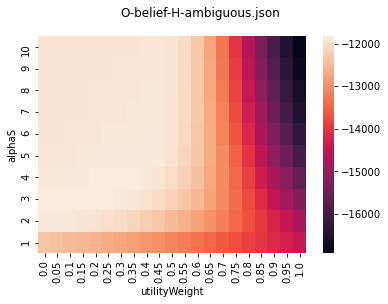

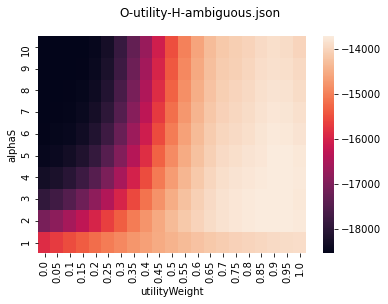

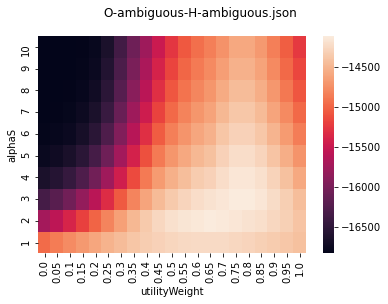

In [32]:
for input_file in slider_input_files:

    try:
        inputs = json.load(open("experiment/webppl-exp2/gridsearch/gridsearch-LH-original-{}".format(input_file)))
    except:
        print("Could not find {}".format(input_file))
        continue
        
    df = pd.DataFrame.from_records(inputs)
    df = df[(df["sigmaGaussian"] == 30) & (df.falsePenalty == -1)]
    df = df[df.alphaS <= 10]

    df.utilityWeight = df.utilityWeight.round(2)

    print("\n\n" + input_file)
        
    print("\nBest parameter values from grid search:")
    
    print_mle(df[df.utilityWeight == 0])
    print_mle(df[df.utilityWeight == 1])
    print_mle(df)
    print("\n")
    print(df.sort_values("likelihood", ascending=False)[["utilityWeight", "alphaS", "alphaL", "sigmaGaussian", "likelihood"]].head(5))
  
    plt.figure()
    pivoted = df.pivot_table(values='likelihood', columns="utilityWeight", index="alphaS", aggfunc='max')
    ax = sns.heatmap(pivoted)
    ax.invert_yaxis()
    plt.suptitle(input_file)

### Bayes Factors

In [33]:
objective = "ambiguous"
horizon = "ambiguous"

input_file = input_string.format(objective, horizon)

combined_exp2 = pd.DataFrame(json.load(open("experiment/webppl-exp2/gridsearch/gridsearch-LH-original-{}".format(input_file))))

print("Bayes factors for {}".format(input_file))

Bayes factors for O-ambiguous-H-ambiguous.json


In [34]:
combined_exp2["utilityWeight"] = combined_exp2.utilityWeight.round(2)

print("\nBF for combined vs pure belief:")
belief_only = combined_exp2[combined_exp2.utilityWeight == 0]
bayes_factors(combined_exp2, belief_only)

print("\nBF for combined vs pure utility")
utility_only = combined_exp2[combined_exp2.utilityWeight == 1]
bayes_factors(combined_exp2, utility_only)


BF for combined vs pure belief:
Comparing M1 (2100 rows) to M2 (100 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 845.734837870581
	M1: -14118.629637564583
	M2: -14964.364475435164

BF for combined vs pure utility
Comparing M1 (2100 rows) to M2 (100 rows).
Bayes Factor (M1 / M2): 5.4347899906855514e+119
Log Bayes Factor: 275.7004469459498
	M1: -14118.629637564583
	M2: -14394.330084510533


/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_20917/277710767.py:18: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_bayes_factor)


### Likelihood Ratio Tests

In [35]:
print("\nCombined vs Belief-Only") 
likelihood_ratio_test(combined_exp2, belief_only, 2)

print("\nCombined vs Action-Only") 
likelihood_ratio_test(combined_exp2, utility_only, 1)


Combined vs Belief-Only
M1 best: UW = 0.75, alphaS = 3.0, log-likelihood: -14111.545626707159
M2 best: UW = 0.0, alphaS = 1.0, log-likelihood: -14962.06189034217
chisq(2) = 1701.032527270021, p = 0.0

Combined vs Action-Only
M1 best: UW = 0.75, alphaS = 3.0, log-likelihood: -14111.545626707159
M2 best: UW = 1.0, alphaS = 2.0, log-likelihood: -14389.724914325356
chisq(1) = 556.3585752363942, p = 5.209019115399311e-123


5.209019115399311e-123

## Per-Participant

Found existing gridsearch-LH-original-W67f94f705a.json
Found existing gridsearch-LH-original-Wc77ad3d1bc.json
Found existing gridsearch-LH-original-W26172bea24.json
Found existing gridsearch-LH-original-W70333eee51.json
Found existing gridsearch-LH-original-W0c171e4019.json
Found existing gridsearch-LH-original-W42ee39db4f.json
Found existing gridsearch-LH-original-W1f755f5517.json
Found existing gridsearch-LH-original-W52d0ff1891.json
Found existing gridsearch-LH-original-Wb3a01ff3ab.json
Found existing gridsearch-LH-original-Wc07caa1726.json
Found existing gridsearch-LH-original-Wa7db587779.json
Found existing gridsearch-LH-original-Wa50064e42e.json
Found existing gridsearch-LH-original-Wd386a6d382.json
Found existing gridsearch-LH-original-W8de1188687.json
Found existing gridsearch-LH-original-Wa0da3f3630.json
Found existing gridsearch-LH-original-Wfefcdeb75f.json
Found existing gridsearch-LH-original-W37fbd5e228.json
Found existing gridsearch-LH-original-Wcef2b7def4.json
Found exis

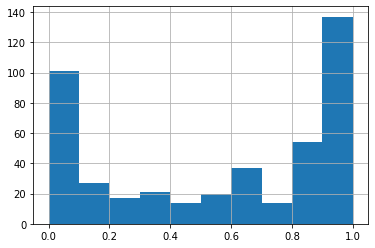

In [36]:
exp2_worker_input_files = os.listdir("experiment/webppl-input/slider/participants/")

grid_search_likelihoods("experiment/webppl-exp2/gridsearch/participants/", exp2_worker_input_files, input_type='slider/participants')

participant_mles = mles_from_participant_gridsearch("exp2")
participant_mles.to_json("experiment/webppl-exp2/participant_mles_via_gridsearch.json", orient='records')

## Objective Manipulation Checks (joint gridsearch)

In [37]:
joint_objective_input = input_string.format("ALL", "ambiguous")
print(joint_objective_input)

input_df = pd.DataFrame(json.load(open(data_path + 'slider/' + joint_objective_input)))
input_df.head()

O-ALL-H-ambiguous.json


,action_context,workerid,objective,horizon,response,utterance
0,"[{'color': 'Blue', 'texture': 'Solid'}, {'colo...",W02b773cfa3,belief,ambiguous,0,"{'feature': 'Red', 'feature_value': -1}"
1,"[{'color': 'Blue', 'texture': 'Solid'}, {'colo...",W05f6e79920,ambiguous,ambiguous,27,"{'feature': 'Red', 'feature_value': -1}"
2,"[{'color': 'Blue', 'texture': 'Solid'}, {'colo...",W079b44d2b6,ambiguous,ambiguous,0,"{'feature': 'Red', 'feature_value': -1}"
3,"[{'color': 'Blue', 'texture': 'Solid'}, {'colo...",W0971403e0c,belief,ambiguous,28,"{'feature': 'Red', 'feature_value': -1}"
4,"[{'color': 'Blue', 'texture': 'Solid'}, {'colo...",W0ae64bdd69,ambiguous,ambiguous,0,"{'feature': 'Red', 'feature_value': -1}"


In [38]:
output_dir = "experiment/webppl-exp2/gridsearch/cross-condition/"

for alphaS in range(1, 11):
    grid_search_likelihoods(output_dir, [joint_objective_input], input_type='slider', 
                            params=f'byObjective {alphaS}', output_fname_extension=f'-alphaS-{alphaS}')

Found existing gridsearch-LH-original-alphaS-1-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-2-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-3-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-4-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-5-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-6-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-7-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-8-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-9-O-ALL-H-ambiguous.json
Found existing gridsearch-LH-original-alphaS-10-O-ALL-H-ambiguous.json


In [39]:
outputs = [o for o in os.listdir(output_dir) if "json" in o]

results = []
for file in outputs:
    results.append(pd.read_json(open(output_dir + file)))

exp2_manipulation_check = pd.concat(results)

In [ ]:
exp2_manipulation_check.sort_values("likelihood", ascending=False).head(3)

In [41]:
ordinal_model_exp2 = exp2_manipulation_check[
    (exp2_manipulation_check["utilityWeight-utility"] > exp2_manipulation_check["utilityWeight-ambiguous"]) &
    (exp2_manipulation_check["utilityWeight-ambiguous"] > exp2_manipulation_check["utilityWeight-belief"])]

single_param_model_exp2 = exp2_manipulation_check[
    (exp2_manipulation_check["utilityWeight-utility"] == exp2_manipulation_check["utilityWeight-ambiguous"]) & 
    (exp2_manipulation_check["utilityWeight-ambiguous"] == exp2_manipulation_check["utilityWeight-belief"])]

print("Exp 2: Manipulation Checks on Belief-biased, Unbiased, Action-biased conditions.")

print("\nBF for ordinal-vs-single:")
bayes_factors(ordinal_model_exp2, single_param_model_exp2)

print("\nBF for ordinal-vs-independent:")
bayes_factors(ordinal_model_exp2, exp2_manipulation_check)

Exp 2: Manipulation Checks on Belief-biased, Unbiased, Action-biased conditions.

BF for ordinal-vs-single:
Comparing M1 (16500 rows) to M2 (1100 rows).
Bayes Factor (M1 / M2): inf
Log Bayes Factor: 1801.491697487385
	M1: -39699.00551113225
	M2: -41500.497208619636

BF for ordinal-vs-independent:
Comparing M1 (16500 rows) to M2 (133100 rows).
Bayes Factor (M1 / M2): 8.066666666631386
Log Bayes Factor: 2.0877403444901574
	M1: -39699.00551113225
	M2: -39701.09325147674


/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_20917/277710767.py:18: RuntimeWarning: overflow encountered in exp
  bayes_factor = np.exp(log_bayes_factor)


# Exp 3

## Grid Search parameters

In [42]:
objectives = ["belief", "utility", "ambiguous"]
horizons = [1, 2, 4]

models = ["combined", "belief", "utility"]

input_string = "O-{}-H-{}.json"

slider_input_files = []

for o in objectives:
    for h in horizons:
        slider_input_files.append(input_string.format(o, h))
        
exp2_possible_condition_files = os.listdir("experiment/webppl-input/slider/")

slider_input_files = [s for s in slider_input_files if s in exp2_possible_condition_files]

In [43]:
results_file_string = "webppl-exp2/gridsearch/gridsearch-LH-original-{}"

In [45]:
output_dir = "experiment/webppl-exp2/gridsearch"
grid_search_likelihoods(output_dir, slider_input_files, input_type='slider')

Found existing gridsearch-LH-original-O-ambiguous-H-1.json
Found existing gridsearch-LH-original-O-ambiguous-H-2.json
Found existing gridsearch-LH-original-O-ambiguous-H-4.json




O-ambiguous-H-1.json

Best parameter values from grid search:
	MLE: UW = 0.0, alphaS = 1.0, alphaL = 10.0, log-likelihood: -14006.86
	MLE: UW = 1.0, alphaS = 2.0, alphaL = 1.0, log-likelihood: -13954.46
	MLE: UW = 0.7, alphaS = 3.0, alphaL = 1.0, log-likelihood: -13437.09


O-ambiguous-H-2.json

Best parameter values from grid search:
	MLE: UW = 0.0, alphaS = 1.0, alphaL = 10.0, log-likelihood: -11712.53
	MLE: UW = 1.0, alphaS = 1.0, alphaL = 1.0, log-likelihood: -12081.49
	MLE: UW = 0.6, alphaS = 3.0, alphaL = 1.0, log-likelihood: -11443.64


O-ambiguous-H-4.json

Best parameter values from grid search:
	MLE: UW = 0.0, alphaS = 1.0, alphaL = 10.0, log-likelihood: -13964.78
	MLE: UW = 1.0, alphaS = 1.0, alphaL = 2.0, log-likelihood: -14296.73
	MLE: UW = 0.65, alphaS = 3.0, alphaL = 1.0, log-likelihood: -13605.68


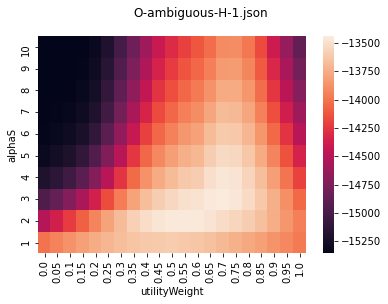

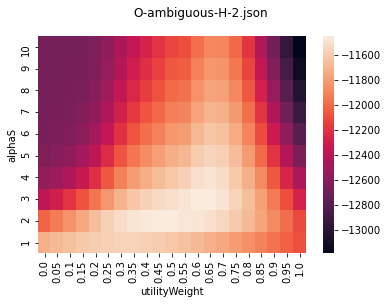

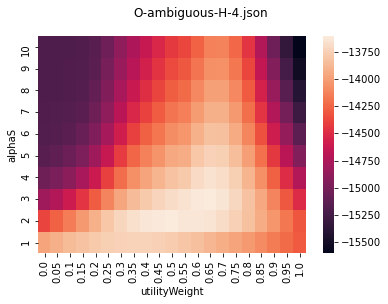

In [46]:
for input_file in slider_input_files:

    try:
        inputs = json.load(open("experiment/webppl-exp2/gridsearch/gridsearch-LH-original-{}".format(input_file)))
    except:
        print("Could not find {}".format(input_file))
        continue
        
    df = pd.DataFrame.from_records(inputs)
    df = df[(df["sigmaGaussian"] == 30) & (df.falsePenalty == -1)]
    df = df[df.alphaS <= 10]

    df.utilityWeight = df.utilityWeight.round(2)

    print("\n\n" + input_file)
        
    print("\nBest parameter values from grid search:")
    
    print_mle(df[df.utilityWeight == 0])
    print_mle(df[df.utilityWeight == 1])
    print_mle(df)
#     print(df.sort_values("likelihood", ascending=False)[["utilityWeight", "alphaS", "alphaL", "sigmaGaussian", "likelihood"]].head(5))
  
    plt.figure()
    pivoted = df.pivot_table(values='likelihood', columns="utilityWeight", index="alphaS", aggfunc='max')
    ax = sns.heatmap(pivoted)
    ax.invert_yaxis()
    plt.suptitle(input_file)

## Horizon Effect (joint gridsearch)

In [47]:
joint_horizon_input = input_string.format("ambiguous", "ALL")

print(joint_horizon_input)

O-ambiguous-H-ALL.json


In [48]:
ls experiment/webppl-input/slider

O-ALL-H-ambiguous.json        O-ambiguous-H-ambiguous.json
O-ambiguous-H-1.json          O-belief-H-ambiguous.json
O-ambiguous-H-2.json          O-utility-H-ambiguous.json
O-ambiguous-H-4.json          participants/
O-ambiguous-H-ALL.json


In [49]:
input_df = pd.DataFrame(json.load(open(data_path + 'slider/' + joint_horizon_input)))
input_df.horizon.value_counts()

4    2736
1    2664
2    2304
Name: horizon, dtype: int64

In [58]:
input_df.columns

Index(['action_context', 'workerid', 'objective', 'horizon', 'response',
       'utterance'],
      dtype='object')

In [ ]:
output_dir = "experiment/webppl-exp3/gridsearch/cross-condition"

for alphaS in range(1, 11):
    grid_search_likelihoods(output_dir, [joint_horizon_input], input_type='slider', 
                            params=f'byHorizon {alphaS}', output_fname_extension=f'-alphaS-{alphaS}')

Could not find gridsearch-LH-original-alphaS-1-O-ambiguous-H-ALL.json.
Read 7704 data from experiment/webppl-input/slider/O-ambiguous-H-ALL.json
undefined
	Ran O-ambiguous-H-ALL.json in 44.78 minutes.
Found existing gridsearch-LH-original-alphaS-2-O-ambiguous-H-ALL.json
Found existing gridsearch-LH-original-alphaS-3-O-ambiguous-H-ALL.json
Found existing gridsearch-LH-original-alphaS-4-O-ambiguous-H-ALL.json
Found existing gridsearch-LH-original-alphaS-5-O-ambiguous-H-ALL.json
Could not find gridsearch-LH-original-alphaS-6-O-ambiguous-H-ALL.json.
Read 7704 data from experiment/webppl-input/slider/O-ambiguous-H-ALL.json


In [ ]:
df = pd.DataFrame(json.load(open(results_file_string.format(joint_horizon_input))))

In [ ]:
df.sort_values("likelihood", ascending=False).head()

In [ ]:
single_param_model = df[(df["utilityWeight-1"] == df["utilityWeight-2"]) &
                        (df["utilityWeight-1"] == df["utilityWeight-4"])]

ordinal_model = df[(df["utilityWeight-1"] > df["utilityWeight-2"]) & 
                   (df["utilityWeight-2"] > df["utilityWeight-4"])]

print(len(single_param_model), len(ordinal_model), len(df))

print("\nBF for ordinal-vs-single:")
bayes_factors(ordinal_model, single_param_model)

print("\nBF for ordinal-vs-independent:")
bayes_factors(ordinal_model, df)

In [ ]:
ordinal_one_v_two = df[df["utilityWeight-1"] > df["utilityWeight-2"]]
ordinal_two_v_four = df[df["utilityWeight-2"] > df["utilityWeight-4"]]

print("\nBF for one-two ordinal vs independent:")
bayes_factors(ordinal_one_v_two, df)

print("\nBF for two-four ordinal vs independent:")
bayes_factors(ordinal_two_v_four, df)

In [ ]:
exp3_worker_input_files = os.listdir("../signaling-bandits-exp/data/webppl-input/slider/participants/")

grid_search_likelihoods("experiment/webppl-exp2/gridsearch/participants/", exp2_worker_input_files, input_type='slider/participants')

participant_mles = mles_from_participant_gridsearch("exp2")
participant_mles.utilityWeight.hist()

participant_mles.to_json("experiment/webppl-exp2/participant_mles_via_gridsearch.json", orient='records')

# Power Analysis by Simulation

In [ ]:
def pvals_from_file(file):
    
    df = pd.DataFrame(json.load(open(f)))
    df["utilityWeight"] = df.utilityWeight.round(2)
    mle_likelihoods = model_likelihoods_from_gridsearch(df)
    
    belief_pval = likelihood_ratio(mle_likelihoods["combined"], mle_likelihoods["belief"], 2)
    utility_pval = likelihood_ratio(mle_likelihoods["combined"], mle_likelihoods["utility"], 1)

    return {"belief": belief_pval, "utility": utility_pval}

## Bootstrapping on Participants

In [ ]:
input_dir = data_path + "select/ambiguous-participants/"
input_files = os.listdir(input_dir)
participants = [p for p in input_files if p[0] == "W"]

In [ ]:
output_dir = "webppl-exp1/power-analysis-bootstrap/"
grid_search_likelihoods(output_dir, participants, input_type='select/ambiguous-participants', verbose=False)

In [ ]:
output_files = [output_dir + "gridsearch-LH-original-" + f for f in participants]

results = []
for f in output_files:
    results.append(pvals_from_file(f))
        
pvals = pd.DataFrame(results)

In [ ]:
pvals[pvals > .05]

# Debug

In [ ]:
script = '{} --require actions --require webppl-json -- --debug'.format(script_path)

!webppl {script}